**Project Description:

This project involves creating a generative AI system for recreating football games using accelerometer data capturing the gait of football players and corresponding action labels. The primary goal is to analyze player movements and actions from the provided data and generate a new game sequence that mimics the original football game. Here are the key components and requirements of the project:

1. **Data Exploration and Analysis**: Conduct a thorough exploration and analysis of the input data to identify differences between various player actions. Understand the distribution of actions, the length of gaits, and other relevant patterns in the data.

2. **Game Recreation Approaches**: Explore and propose different approaches for recreating the football game. These approaches could include using machine learning algorithms, time series analysis, sequence-to-sequence models, Hidden Markov Models (HMM), and more.

3. **Data Pre-processing and Post-processing**: Implement data pre-processing techniques, such as data normalization, padding, label encoding, and data balancing. Also, define the post-processing steps for combining accelerometer data and action labels to generate the game sequence.

4. **Algorithm/Model Parametrization**: Develop an algorithm or model that allows generating as many games as needed and specifying the game's length. Optionally, provide the capability to generate games with specific playstyles (e.g., attacking, defending, normal).

This project requires a combination of data analysis, machine learning, and sequence generation techniques to achieve the goal of recreating football games based on accelerometer data. The primary output of the project is a generative AI system that can create football game sequences given the input data, with a focus on realism and accuracy.

# 1-EDA

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf



In [2]:
# Load the JSON data from a file
with open('C://Users//33751//OneDrive//Bureau//entretien//Use_Case_Footbar//match_1.json', 'r') as json_file:
    df = pd.DataFrame(json.load(json_file))

In [3]:
df.head()

,label,norm
0,walk,"[23.177037336396975, 23.36152528524938, 21.535..."
1,walk,"[20.998214383911275, 19.182798059840767, 18.27..."
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554..."
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787..."
4,rest,"[22.069263037713093, 19.672270483203395, 19.88..."


In [4]:
# 1. Data Overview
print("Data Overview:")
print(df.info())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   574 non-null    object
 1   norm    574 non-null    object
dtypes: object(2)
memory usage: 9.1+ KB
None


In [5]:
# 2. Data Summary Statistics
# Display summary statistics for the 'norm' column
print("\nSummary Statistics for 'norm' column:")
print(df['norm'].describe())


Summary Statistics for 'norm' column:
count                                                   574
unique                                                  574
top       [23.177037336396975, 23.36152528524938, 21.535...
freq                                                      1
Name: norm, dtype: object


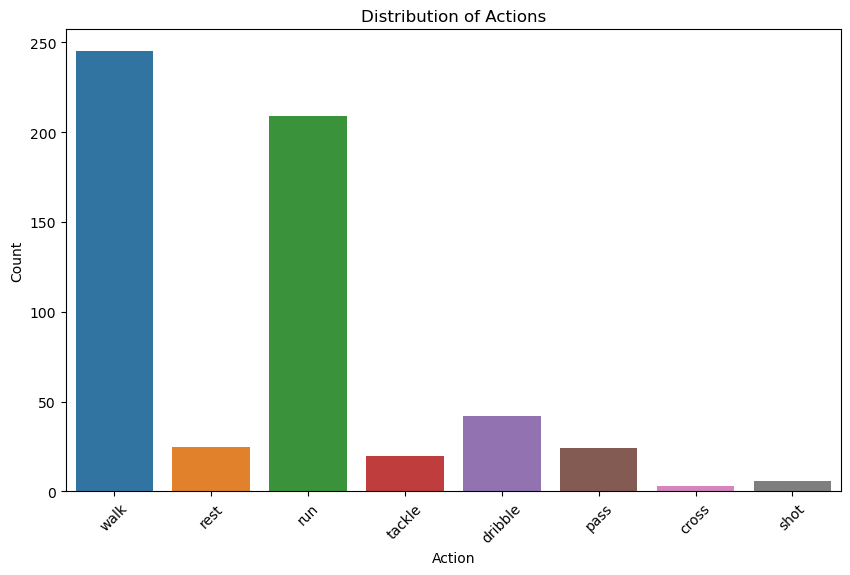

In [6]:
# 3. Action Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label')
plt.title("Distribution of Actions")
plt.xlabel("Action")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

C:\Users\33751\AppData\Local\Temp\ipykernel_42468\3412340020.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sequence_lengths = df.groupby('label')['norm'].apply(lambda x: x.apply(len))


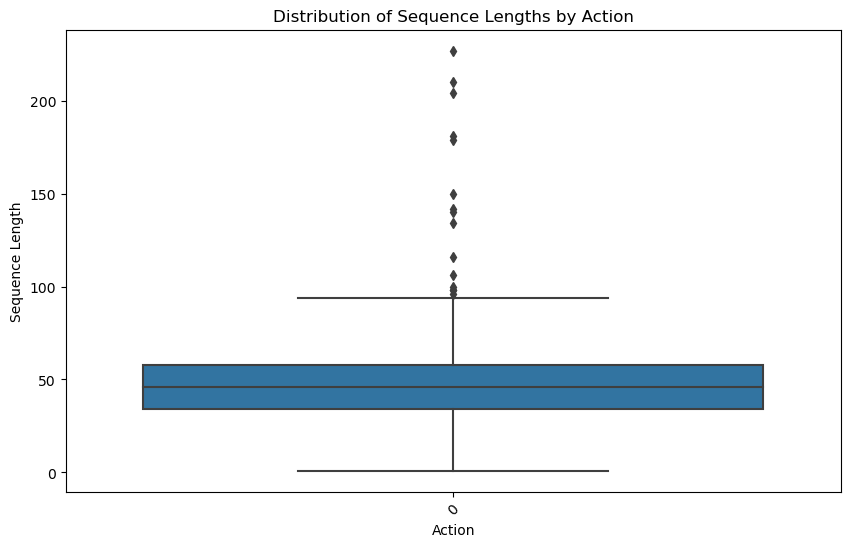

In [7]:
# Sequence Length Analysis
sequence_lengths = df.groupby('label')['norm'].apply(lambda x: x.apply(len))
plt.figure(figsize=(10, 6))
sns.boxplot(data=sequence_lengths)
plt.title("Distribution of Sequence Lengths by Action")
plt.xlabel("Action")
plt.ylabel("Sequence Length")
plt.xticks(rotation=45)
plt.show()

In [13]:
# Sampling frequency (change this to your actual sampling frequency)
sampling_frequency = 50  

# Calculate duration for each gait
df['duration'] = df['norm'].apply(lambda x: len(x) / sampling_frequency)
df

,label,norm,duration
0,walk,"[23.177037336396975, 23.36152528524938, 21.535...",1.44
1,walk,"[20.998214383911275, 19.182798059840767, 18.27...",1.08
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554...",1.36
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787...",1.50
4,rest,"[22.069263037713093, 19.672270483203395, 19.88...",3.62
...,...,...,...
569,walk,"[21.245737438782683, 21.938836193196945, 21.24...",1.70
570,walk,"[20.272347748199333, 21.820302584302983, 21.21...",0.96
571,run,"[90.21306005395827, 72.12712844635696, 63.5643...",0.64
572,tackle,"[44.79510251441832, 27.26406867633046, 88.6164...",1.28


In [14]:
df

,label,norm,duration
0,walk,"[23.177037336396975, 23.36152528524938, 21.535...",1.44
1,walk,"[20.998214383911275, 19.182798059840767, 18.27...",1.08
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554...",1.36
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787...",1.50
4,rest,"[22.069263037713093, 19.672270483203395, 19.88...",3.62
...,...,...,...
569,walk,"[21.245737438782683, 21.938836193196945, 21.24...",1.70
570,walk,"[20.272347748199333, 21.820302584302983, 21.21...",0.96
571,run,"[90.21306005395827, 72.12712844635696, 63.5643...",0.64
572,tackle,"[44.79510251441832, 27.26406867633046, 88.6164...",1.28


In [10]:
# Calculate mean duration for each label
mean_duration_by_label = df.groupby('label')['duration'].mean()

# Display the mean duration for each label
mean_duration_by_label

label
cross      1.200000
dribble    0.831905
pass       0.802500
rest       1.790400
run        0.766603
shot       0.556667
tackle     0.884000
walk       1.114857
Name: duration, dtype: float64

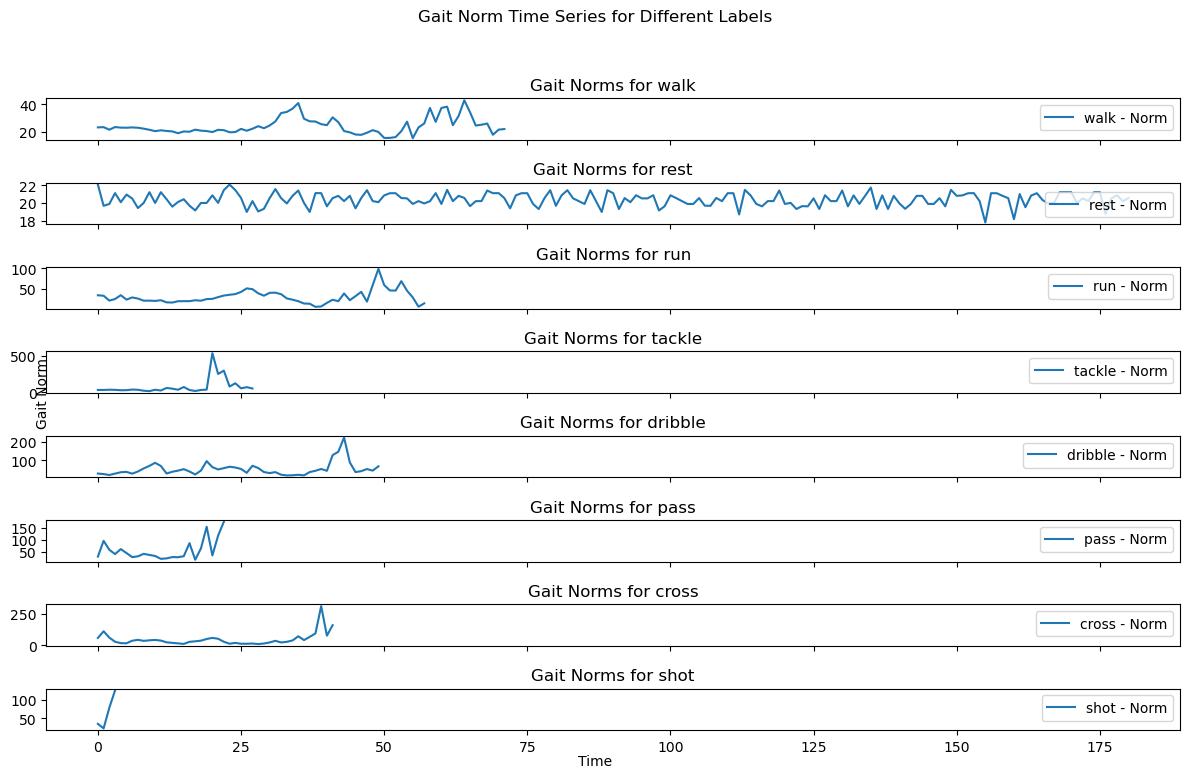

In [15]:
# Create a separate graph for each label
unique_labels = df['label'].unique()

fig, axes = plt.subplots(nrows=len(unique_labels), figsize=(12, 8), sharex=True)

for i, label in enumerate(unique_labels):
    current_label_data = df[df['label'] == label]['norm'].iloc[0]
    axes[i].plot(current_label_data, label=f'{label} - Norm')
    axes[i].set_title(f'Gait Norms for {label}')
    axes[i].legend()

# Set common labels and title
fig.text(0.5, 0.04, 'Time', ha='center', va='center')
fig.text(0.04, 0.5, 'Gait Norm', ha='center', va='center', rotation='vertical')
fig.suptitle('Gait Norm Time Series for Different Labels')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

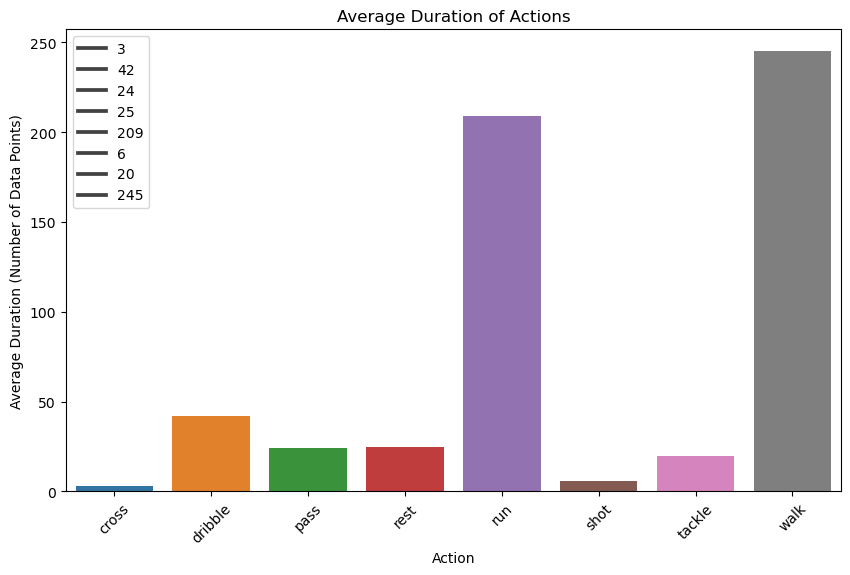

In [16]:
# Action Duration Analysis
action_durations = df.groupby('label')['norm'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
sns.barplot(x=action_durations.index, y=action_durations.values)
plt.title("Average Duration of Actions")
plt.xlabel("Action")
plt.ylabel("Average Duration (Number of Data Points)")
plt.legend(action_durations)
plt.xticks(rotation=45)
plt.show

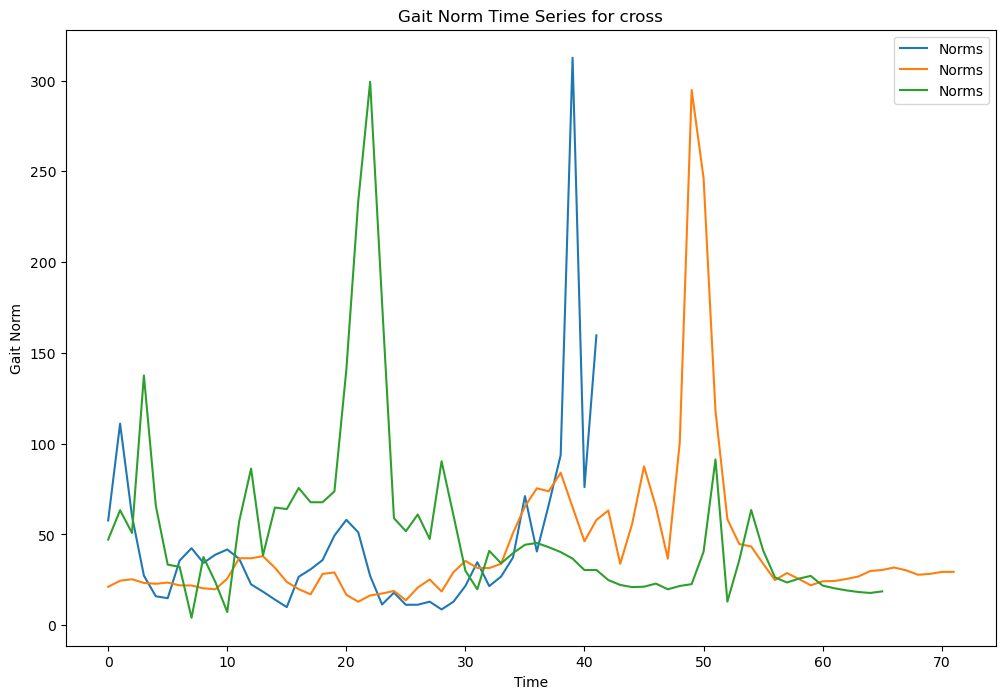

In [17]:
# Choose the label for which you want to plot all norms
selected_label = 'cross'

# Filter the DataFrame for the selected label
selected_label_data = df[df['label'] == selected_label]['norm'].tolist()

# Plot all norms for the selected label
plt.figure(figsize=(12, 8))
for norms in selected_label_data:
    plt.plot(norms, label='Norms')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Gait Norm')
plt.title(f'Gait Norm Time Series for {selected_label}')
plt.legend()

# Display the plot
plt.show()

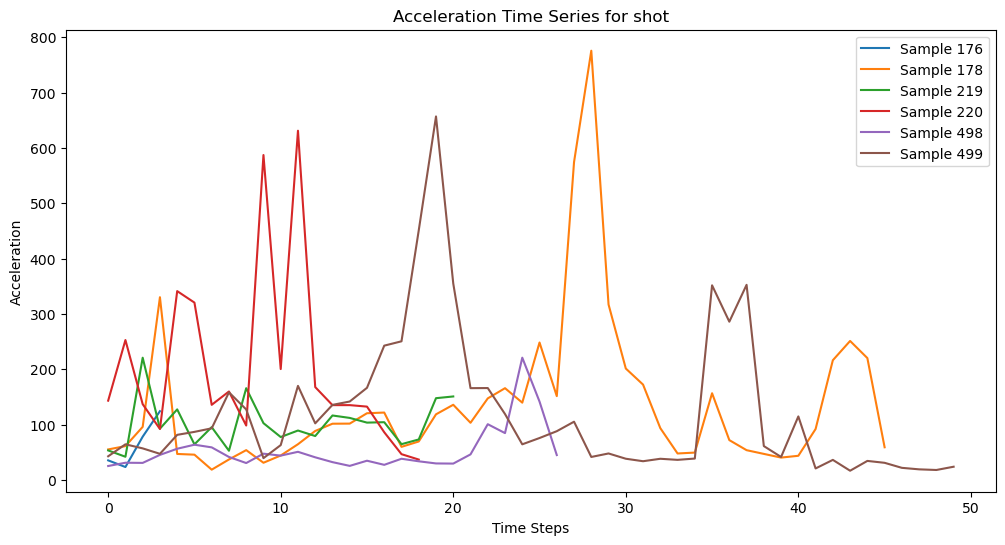

In [18]:
# Time Series Visualization for a specific action (e.g., 'shot')
action_to_plot = 'shot'
subset_df = df[df['label'] == action_to_plot]
plt.figure(figsize=(12, 6))
for idx, row in subset_df.iterrows():
    plt.plot(row['norm'], label=f'Sample {idx}')
plt.title(f"Acceleration Time Series for {action_to_plot}")
plt.xlabel("Time Steps")
plt.ylabel("Acceleration")
plt.legend(loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

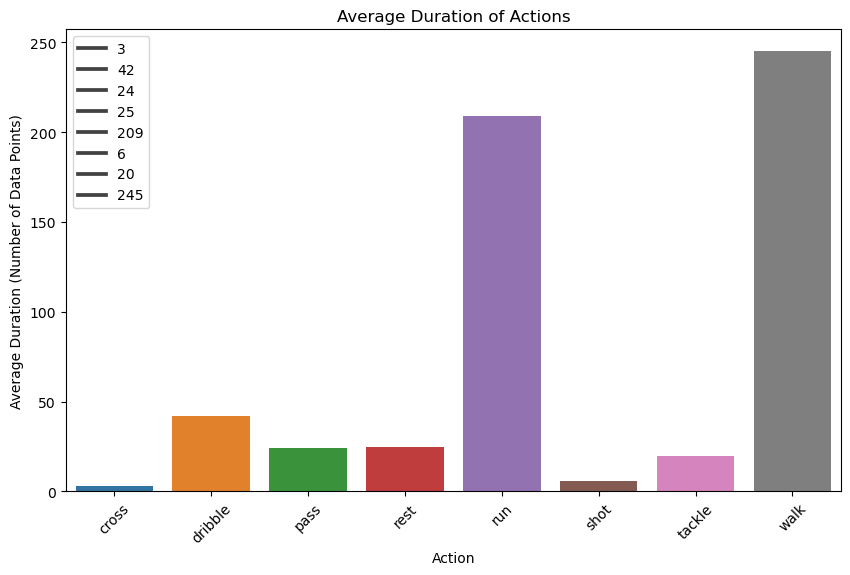

In [19]:
# Action Duration Analysis
action_durations = df.groupby('label')['norm'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
sns.barplot(x=action_durations.index, y=action_durations.values)
plt.title("Average Duration of Actions")
plt.xlabel("Action")
plt.ylabel("Average Duration (Number of Data Points)")
plt.legend(action_durations)
plt.xticks(rotation=45)
plt.show

In this section, we've performed exploratory data analysis (EDA) to understand the dataset. We've visualized the distribution of actions, examined sequence lengths for different actions, and even visualized a specific action's time series. The action duration analysis provides insights into the average length of each action.


In [20]:
for i in df['label'].unique():
    av_len_action=[len(l) for l in df[df['label']==i]['norm']]
    print("Average length of the gait "+i,np.mean(av_len_action))

Average length of the gait walk 55.74285714285714
Average length of the gait rest 89.52
Average length of the gait run 38.33014354066986
Average length of the gait tackle 44.2
Average length of the gait dribble 41.595238095238095
Average length of the gait pass 40.125
Average length of the gait cross 60.0
Average length of the gait shot 27.833333333333332


# Approaches for Football Game Recreation

## 1. **Supervised Learning - Time Series Analysis**

   - **Algorithm Choice:** Long Short-Term Memory (LSTM) networks or other recurrent neural networks (RNNs).
   - **Training Model:** Predict player actions at each time step based on historical accelerometer readings.

## 2. **Supervised Learning - Classical Machine Learning**

   - **Feature Extraction:** Extract relevant features from accelerometer data.
   - **Models:** Use classical machine learning models (e.g., Random Forest, Support Vector Machines) for action prediction.

## 3. **Semi-Supervised Learning**

   - **Unlabeled Data:** Utilize a combination of labeled and unlabeled data.
   - **Self-Supervised Learning:** Leverage self-supervised learning techniques.

## 4. **Transfer Learning**

   - **Pre-trained Models:** Use pre-trained models on a large dataset.
   - **Domain Adaptation:** Adapt models trained on similar tasks to the football game scenario.

## 5. **Ensemble Learning**

   - **Model Combination:** Combine predictions from multiple models.
   - **Voting Mechanisms:** Use ensemble techniques like bagging or boosting.

## 6. **Unsupervised Learning - Clustering**

   - **Cluster Similar Sequences:** Apply clustering algorithms.
   - **Discover Patterns:** Identify patterns within clusters.

## 7. **Rule-Based Systems**

   - **Expert Knowledge:** Encode expert knowledge about football gameplay rules.
   - **Decision Trees:** Create decision trees for decision-making processes.

## 11. **Multi-Modal Learning**

   - **Combine Data Sources:** Integrate data from multiple modalities.
   - **Fusion Techniques:** Use fusion techniques for more robust predictions.



# Model Architecture:

## Reasons for Choosing LSTM for Football Gait Analysis

1. **Sequential Nature of Gait Data:**
   - Accelerometer data capturing gait is inherently sequential. Each data point is not independent but is influenced by the previous data points in the time series. LSTMs are designed to model sequential dependencies, making them well-suited for tasks where the order of the data is important.

2. **Handling Temporal Dynamics:**
   - The gait of football players involves complex temporal dynamics. LSTMs excel at capturing and learning patterns over different time scales, allowing them to capture the nuanced variations in acceleration that are indicative of specific actions or movements.

3. **Long-Term Dependencies:**
   - Gait analysis often requires capturing long-term dependencies in the movement patterns. LSTMs, with their memory cells and gating mechanisms, are effective in learning and retaining information over extended periods, which is crucial for understanding the context of different actions in a football game.

4. **Recognition of Action Sequences:**
   - LSTMs are well-suited for recognizing patterns and sequences of actions. In the context of football, different actions such as walking, running, sprinting, or sudden changes in direction can be identified based on the sequential patterns in accelerometer data.

5. **Adaptability to Varying Gait Speeds:**
   - Football players exhibit varying gait speeds during a game. LSTMs are capable of adapting to different speeds and can learn to recognize actions regardless of the pace at which they are performed.

6. **Gating Mechanism for Noise Reduction:**
   - Accelerometer data can be noisy, and irrelevant variations may be present. LSTMs' gating mechanisms, which control the flow of information, can help filter out noise and focus on the relevant features for action recognition.

7. **Training on Varied Sequences:**
   - LSTMs can be trained on sequences of varying lengths, accommodating the fact that different actions in football may have different durations. This flexibility is crucial for modeling the dynamic nature of gait.

8. **Previous Success in Time Series Tasks:**
   - LSTMs have demonstrated success in various time series tasks, including speech recognition, natural language processing, and time series prediction. Their effectiveness in handling sequential data makes them a reasonable choice for gait analysis in football.

![LSTM Architecture](https://www.researchgate.net/profile/Amin-Karimi-Dastgerdi/publication/372595613/figure/fig1/AS:11431281177242857@1690405482143/Flowchart-of-the-proposed-NNA-LSTM-model.png)

# Data Preprocessing

the first step is to pad the norm data so that all gaits have the same length. so it will add 0 in the short gaits.

we also have to encode the label variable

The code you provided is using Synthetic Minority Over-sampling Technique (SMOTE) to balance the dataset. SMOTE is a technique commonly used in machine learning to address class imbalance by oversampling the minority class, creating synthetic samples.

Feature engineering with mean and standard deviation can provide additional information to the model about the central tendency and variability of the data, potentially improving its performance.

In [28]:
def preprocess_data(X_column, y_column, max_sequence_length=100, test_size=0.3, random_state=10):
    # Data Padding
    X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_column.tolist(), padding='post', maxlen=max_sequence_length, dtype='float32')

    # Label Encoding
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(y_column)

    X = X_padded
    y = numerical_labels

    # Data Balancing with SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=10, k_neighbors=2)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Feature Engineering
    mean_values = np.mean(X_resampled, axis=1)
    std_values = np.std(X_resampled, axis=1)
    X_with_mean_std = np.hstack((X_resampled, mean_values.reshape(-1, 1), std_values.reshape(-1, 1)))

    # Splitting the preprocessed data into three sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_with_mean_std, y_resampled, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test



X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df['norm'], df['label'])




In [29]:

# Get the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Mapping:")
for label, code in label_mapping.items():
    print(f"{label}: {code}")

Label Mapping:
cross: 0
dribble: 1
pass: 2
rest: 3
run: 4
shot: 5
tackle: 6
walk: 7


In [32]:
def train_lstm_model(X_train, y_train, X_val, y_val, play_mode, lstm_units=128, dropout_rate=0.3, learning_rate=0.001, epochs=10, batch_size=32):
    input_shape = X_train.shape[1:]

    lstm_model = create_lstm_model(input_shape, num_classes=len(np.unique(y_train)),
                                   lstm_units=lstm_units, dropout_rate=dropout_rate)

    custom_optimizer = Adam(learning_rate=learning_rate)
    lstm_model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    class_weights = get_class_weights(play_mode)  # Define class weights based on play mode

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with the specified class weights
    history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping],
                              class_weight=class_weights, verbose=1)


    return lstm_model, history

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna

def create_lstm_model(input_shape, num_classes, lstm_units=128, dropout_rate=0.3):
    model = models.Sequential()
    model.add(layers.LSTM(lstm_units, input_shape=input_shape, return_sequences=True))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

def get_class_weights(play_mode):
    if play_mode == 'normal':
        class_weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
    elif play_mode == 'attacking':
        class_weights = {0: 5.0, 1: 7.0, 2: 4.0, 3: 1.0, 4: 8.0, 5: 8.0, 6: 4.0, 7: 1.0}
    elif play_mode == 'defending':
        class_weights = {0: 2.0, 1: 1.0, 2: 4.0, 3: 2.0, 4: 5.0, 5: 1.0, 6: 7.0, 7: 1.0}
    else:
        raise ValueError("Invalid play mode")

    return class_weights

def objective(trial):
    # Hyperparameter search space
    lstm_units = trial.suggest_int('lstm_units', 64, 256)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    epochs = trial.suggest_int('epochs', 5, 20)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    input_shape = X_train.shape[1:]
    lstm_model = create_lstm_model(input_shape, num_classes=len(np.unique(y_train)),
                                   lstm_units=lstm_units, dropout_rate=dropout_rate)

    custom_optimizer = Adam(learning_rate=learning_rate)
    lstm_model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    class_weights = get_class_weights(play_mode)  # Define class weights based on play mode

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with the specified class weights
    history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping],
                              class_weight=class_weights, verbose=0)

    # Return the validation accuracy for optimization
    val_loss, val_acc = lstm_model.evaluate(X_val, y_val, verbose=0)
    return val_loss  # Optuna minimizes the objective, so negate accuracy


# Convert X_train, X_val, and X_test to 3D arrays (samples, time steps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


# Fine-tune hyperparameters using Optuna
play_mode = 'normal'  # Choose the play mode
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters from the study
best_params = study.best_params
best_lstm_units = best_params['lstm_units']
best_dropout_rate = best_params['dropout_rate']
best_learning_rate = best_params['learning_rate']
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']

# Train the model with the best hyperparameters
best_model, best_history = train_lstm_model(X_train, y_train, X_val, y_val, play_mode,
                                            lstm_units=best_lstm_units, dropout_rate=best_dropout_rate,
                                            learning_rate=best_learning_rate, epochs=best_epochs, batch_size=best_batch_size)

# Use the best trained model for inference or further evaluation on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy for {play_mode} with fine-tuned hyperparameters: {test_acc * 100:.2f}%")


Epoch 1/13
43/43 [==============================] - 20s 322ms/step - loss: 1.7982 - accuracy: 0.4023 - val_loss: 1.1862 - val_accuracy: 0.5795
Epoch 2/13
43/43 [==============================] - 13s 295ms/step - loss: 1.0709 - accuracy: 0.6035 - val_loss: 0.7840 - val_accuracy: 0.6761
Epoch 3/13
43/43 [==============================] - 8s 193ms/step - loss: 0.7739 - accuracy: 0.7208 - val_loss: 0.5392 - val_accuracy: 0.7841
Epoch 4/13
43/43 [==============================] - 8s 184ms/step - loss: 0.6218 - accuracy: 0.7799 - val_loss: 0.4734 - val_accuracy: 0.8352
Epoch 5/13
43/43 [==============================] - 9s 218ms/step - loss: 0.5002 - accuracy: 0.8098 - val_loss: 0.3872 - val_accuracy: 0.8722
Epoch 6/13
43/43 [==============================] - 9s 198ms/step - loss: 0.4275 - accuracy: 0.8375 - val_loss: 0.3400 - val_accuracy: 0.8693
Epoch 7/13
43/43 [==============================] - 8s 180ms/step - loss: 0.3739 - accuracy: 0.8571 - val_loss: 0.2893 - val_accuracy: 0.8949
Epoc

we have 8 classes and 102 sequences

8/8 [==============================] - 3s 127ms/step


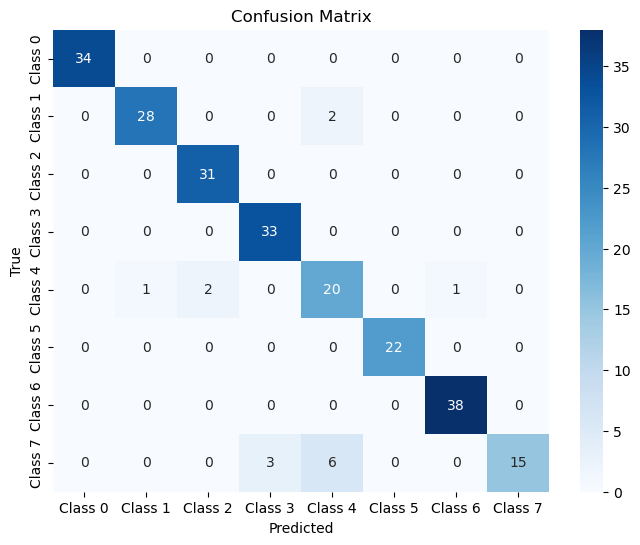

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [35]:

# Get the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Mapping:")
for label, code in label_mapping.items():
    print(f"{label}: {code}")

Label Mapping:
cross: 0
dribble: 1
pass: 2
rest: 3
run: 4
shot: 5
tackle: 6
walk: 7


## Game generation 

In [41]:
def generate_game_sequences(model, X, label_encoder, num_games=1, num_minutes=10):
    # List to store the generated game sequences
    generated_games = []
    X = np.expand_dims(X, axis=-1)
    for _ in range(num_games):
        # Define the number of time steps per second
        time_steps_per_second = 0.5  # Each action takes 2 seconds, so there are 0.5 actions per second

        # Calculate the total number of time steps for the specified number of minutes
        num_time_steps = int(num_minutes * 60 * time_steps_per_second)
        
        # Initialize a game sequence for this iteration
        generated_game = []

        for _ in range(num_time_steps):
            # Append the next accelerometer reading from your dataset
            seed_sequence = X[_ % len(X)]
            # Add an extra dimension to match the model's input shape
            seed_sequence = np.expand_dims(seed_sequence, axis=0)
            # Predict the next action label using the model
            predicted_action = model.predict(seed_sequence)

            # Decode the predicted label back to its original form
            predicted_label = label_encoder.inverse_transform(np.argmax(predicted_action, axis=1))

            # Append the predicted action to the generated game
            generated_game.append({'norm': seed_sequence[0].tolist(), 'label': predicted_label[0]})

        # Append the generated game sequence to the list of games
        generated_games.append(generated_game)

    return generated_games


In [42]:
generated_games = generate_game_sequences(best_model, X_with_mean_std, label_encoder, num_games=2, num_minutes=10)

1/1 [==============================] - 0s 63ms/step


In [43]:
#game 1
np.array((pd.DataFrame(generated_games[1])['label']))

array(['walk', 'walk', 'walk', 'rest', 'rest', 'walk', 'walk', 'walk',
       'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run',
       'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'walk', 'walk',
       'walk', 'tackle', 'run', 'run', 'run', 'run', 'run', 'run', 'run',
       'run', 'walk', 'walk', 'run', 'run', 'run', 'run', 'run', 'run',
       'run', 'run', 'run', 'run', 'pass', 'run', 'run', 'run', 'run',
       'run', 'run', 'run', 'run', 'run', 'tackle', 'dribble', 'dribble',
       'dribble', 'pass', 'pass', 'walk', 'walk', 'walk', 'walk', 'walk',
       'walk', 'walk', 'walk', 'walk', 'run', 'run', 'run', 'run', 'run',
       'run', 'run', 'run', 'run', 'walk', 'walk', 'run', 'run', 'rest',
       'walk', 'run', 'walk', 'walk', 'walk', 'walk', 'rest', 'run',
       'run', 'run', 'run', 'run', 'dribble', 'run', 'pass', 'run',
       'dribble', 'run', 'run', 'walk', 'run', 'run', 'run', 'walk',
       'run', 'walk', 'walk', 'walk', 'run', 'run', 'run', 'tackle',

In [44]:
# Add the ".json" file extension to the user-provided name
file_path = f"{'generated_games'}"

# Save the data as a JSON file in the current working directory
with open(f"{file_path}.json", "w") as json_file:
    json.dump(generated_games, json_file)

print(f"Data saved to JSON file: {file_path}")

Data saved to JSON file: generated_games
